## Acoustic Scene Detection V5

In diesem Programmcode wird der Datensatz geldaden, Verarbeitet und das CNN trainiert. Nach dem Training ist die Evaluierung möglich, bei der die Performance und die Inferenzzeit berechnet wird.

Nutzung von ChatGPT: 
Die Dataloader Class und die Funktion Compute_MFCC wurde mit Hilfe von generativer KI erstellt.

Prompts:

# compute_tf_mfcc:
 "Erstelle mir eine MFCC berechnung mit der Tensorflow Bibliothek. Nutze dabei die Selbe Implementierung wie hier:

stfts = tf.signal.stft(pcm, frame_length=FFTSize, frame_step=frame_step,
                       fft_length=FFTSize,
                       window_fn=tf.signal.hamming_window)
spectrograms = tf.abs(stfts)



num_spectrogram_bins = stfts.shape[-1]
lower_edge_hertz, upper_edge_hertz, num_mel_bins = freq_min, freq_high, numOfMelFilters
linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
  num_mel_bins, num_spectrogram_bins, sample_rate, lower_edge_hertz,
  upper_edge_hertz,dtype=tf.double)

#print(spectrograms.dtype)
#print(linear_to_mel_weight_matrix.dtype)
mel_spectrograms = tf.tensordot(
  spectrograms, linear_to_mel_weight_matrix, 1)
mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
  linear_to_mel_weight_matrix.shape[-1:]))

log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

mfccsT = tf.signal.mfccs_from_log_mel_spectrograms(
  log_mel_spectrograms)[..., :numOfDctOutputs]
"
# Dataloader

" Erstelle mir eine Pytorch Dataloader Klasse um aus einem Datensatz Audiodatein zu laden und diese zu verarbeiten"


In [1]:
import os
from contextlib import suppress

from tqdm.auto import tqdm

import distiller # required for quantization

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchaudio
import torchaudio.transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np

from errno import ENOENT

import max78_modules.ai8x as ai8x

%matplotlib inline

2025-02-21 17:13:27.565190: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 17:13:27.591223: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-21 17:13:27.912076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.is_available()


True

# Setup device

In [3]:
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

## 85 für max78000, 87 für max78002
args = Args(act_mode_8bit=False)
ai8x.set_device(85, simulate=False, round_avg=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Configuring device: MAX78000, simulate=False.


# Setup TUT2017 dataset and dataloader

- Hier kann man die Parameter für Audio Preprocessing festlegen
- Audio To mono fehlt noch

In [4]:
def compute_tf_mfcc(waveform, sample_rate, window_length, hop_length, num_mel_bins=40, num_mfcc=40):
    """
    Berechnet MFCCs mit TensorFlow aus einer 1D-Waveform.
    
    Args:
        waveform (tf.Tensor): 1D Tensor (Samples).
        sample_rate (int): Samplingrate.
        window_length (int): Länge des STFT-Fensters.
        hop_length (int): Schrittweite zwischen den Fenstern.
        num_mel_bins (int): Anzahl der Mel-Bins.
        num_mfcc (int): Anzahl der MFCC-Koeffizienten.
        
    Returns:
        mfccs (tf.Tensor): Tensor der Form (Time, num_mfcc)
    """
    # Berechne die Short-Time Fourier Transform (STFT)
    stfts = tf.signal.stft(waveform,
                           frame_length=window_length,
                           frame_step=hop_length,
                           fft_length=window_length,
                           window_fn=tf.signal.hann_window,
                           pad_end=False)
    spectrograms = tf.abs(stfts)

    # Erzeuge die lineare -> mel Gewichtsmatrix
    num_spectrogram_bins = spectrograms.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, 0, sample_rate / 2)
    
    # Wende die Gewichtsmatrix an
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, axes=1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    
    # Logarithmische Skalierung (kleiner Offset, um log(0) zu vermeiden)
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    
    # Berechne die MFCCs und behalte die ersten num_mfcc Koeffizienten
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfcc]
    return mfccs

In [5]:




class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None, sample_rate=16000):
        """
        Args:
            root_dir (string): Directory with all the folders (e.g., cafe, car, city_center, etc.).
            transform (callable, optional): Optional transform to be applied on a sample.
            sample_rate (int): Desired sample rate for the audio files.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.sample_rate = sample_rate
        self.data = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        
        # Build the dataset
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for file_name in os.listdir(class_dir):
                    file_path = os.path.join(class_dir, file_name)
                    if file_name.endswith('.wav'):  # Check for .wav files
                        self.data.append(file_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path = self.data[idx]
        label = self.labels[idx]
        
        # Load the audio file
        waveform, sample_rate = torchaudio.load(file_path)
        
        waveform = waveform.mean(dim=0)  # Mittelung über die Kanal-Dimension

        # Resample if necessary
        if sample_rate != self.sample_rate:
            resample_transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.sample_rate)
            waveform = resample_transform(waveform)

        

        # Nun verwenden wir die gewünschte Sample-Rate für alle weiteren Berechnungen
        sr = self.sample_rate
        # Berechne Fenster- und Hop-Länge (Beispielwerte: 92 ms Fenster, 46 ms Schritt)

        
        # Umwandlung des PyTorch-Tensors in ein NumPy-Array (auf CPU)
        waveform_np = waveform.cpu().numpy()
        # Falls nötig: Entferne zusätzliche Dimensionen (sollte 1D sein)
        waveform_np = np.squeeze(waveform_np)
        
        # Konvertiere in einen TensorFlow-Tensor
        waveform_tf = tf.convert_to_tensor(waveform_np, dtype=tf.float32)
        
        # Berechne die MFCCs mit TensorFlow
        mfccs_tf = compute_tf_mfcc(waveform_tf, sample_rate=sr, window_length=1024, hop_length=512)
        # Konvertiere zurück in ein NumPy-Array
        mfccs_np = mfccs_tf.numpy()
        # Und schließlich in einen PyTorch-Tensor
        mfccs_tensor = torch.tensor(mfccs_np, dtype=torch.float32)

        # Transponiere die Dimensionen, um das gewünschte Format (num_mfcc, Zeit) zu erhalten
        mfccs_tensor = mfccs_tensor.transpose(0, 1)
        

        transform_normalize = ai8x.normalize(args = args)
        waveform = transform_normalize(mfccs_tensor)
        
        
        return waveform, label

In [6]:
train_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Training"
val_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Validation"
test_dataset_path = "/home/student42/Documents/Datset/KerasTUT2017_16khz_FULL/Testing"

batch_size = 32
TUT2017_train = AudioDataset(root_dir=train_dataset_path, transform=None, sample_rate=16000)
TUT2017_val = AudioDataset(root_dir=val_dataset_path, transform=None, sample_rate=16000)
TUT2017_test = AudioDataset(root_dir=test_dataset_path, transform=None, sample_rate=16000)

dataset_train = DataLoader(TUT2017_train, batch_size=batch_size, shuffle=True)
dataset_val = DataLoader(TUT2017_val, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(TUT2017_test, batch_size=batch_size, shuffle=True)

dataset_labels = [0, 1, 2, 3, 4, 5, 6]

In [ ]:
# Beispiel: Zugriff auf Daten aus dem Train-Loader
for waveforms, labels in dataset_train:
    print("Train Data - Waveforms Shape:", waveforms.shape)
    print("Train Data - Labels Shape:", labels.shape)
    break



2025-02-21 17:13:42.817704: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-21 17:13:42.850536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-21 17:13:42.854954: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Train Data - Waveforms Shape: torch.Size([32, 40, 311])
Train Data - Labels Shape: torch.Size([32])
Validation Data - Waveforms Shape: torch.Size([32, 40, 311])
Validation Data - Labels Shape: torch.Size([32])


# Create CNN Model

In [9]:


class Custom1DCNNForImage(nn.Module):
    
    def __init__(
            self,
            num_classes=7,
            num_channels=40,
            bias=True,
            **kwargs

    ):
        super(Custom1DCNNForImage, self).__init__()


        self.drop = nn.Dropout(p=0.2)
        # Erste Convolutional Layer mit Batch-Normalisierung und ReLU
        self.conv1 = ai8x.FusedConv1dReLU(num_channels, 64, 5, stride=1, padding=0,
                                                bias=bias, **kwargs)
        
        # # torch.Size([1, 64, 307])
        self.conv2 = ai8x.FusedConv1dReLU(64, 128, 3, stride=1, padding=0,
                                                 bias=bias, **kwargs)
        # torch.Size([1, 128, 305])
        self.conv3 = ai8x.FusedMaxPoolConv1dReLU(128, 256, 5, stride=1, padding=1,
                                                       bias=bias, **kwargs)
        # # torch.Size([1, 256, 150])
        self.conv4 = ai8x.FusedAvgPoolConv1dReLU(256, 64, 3, stride=1, padding=1,
                                                     bias=bias, **kwargs)
        # # torch.Size([1, 64, 75])
        self.conv5 = ai8x.FusedMaxPoolConv1dReLU(64, 32, 6, stride=1, padding=0,
                                                     bias=bias, **kwargs)
        # # torch.Size([1, 32, 32])
        self.fc = ai8x.Linear(1024, num_classes, bias=bias, wide=True, **kwargs)

    def forward(self, x):  # pylint: disable=arguments-differ
        """Forward prop"""
        # Run CNN
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = self.drop(x)
        
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


# Beispielinstanz
model = Custom1DCNNForImage()

# Test mit einem Beispielinput
input_tensor = torch.randn(1, 40, 311)  # Batch size 1, 40 Kanäle, Länge 313
output = model(input_tensor)
print(output.shape)  # Sollte (1, 7) sein



torch.Size([1, 7])


# Define loss function and optimizer

In [10]:
compression_scheduler = distiller.CompressionScheduler(model)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.25, patience=2, min_lr=1e-7)
criterion = nn.CrossEntropyLoss()

qat_policy = { 'weight_bits': 8 }
vloss = 10**6
steps_per_epoch = (len(dataset_train.sampler) + batch_size - 1)

# Train the model

In [11]:
# Define the number of training epochs
num_epochs = 10    # FP training epochs
num_epochs_qat = 10  # QAT training epochs


Epoch [1/10] - Loss: 1.7095 - Train Accuracy: 29.62%
Epoch [1/10] - Test Accuracy: 37.10%


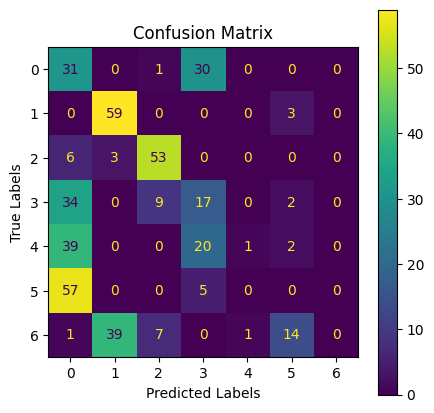


Epoch [2/10] - Loss: 1.0599 - Train Accuracy: 57.80%
Epoch [2/10] - Test Accuracy: 52.76%


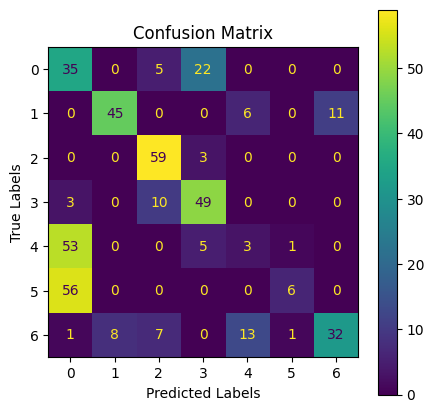


Epoch [3/10] - Loss: 0.8116 - Train Accuracy: 67.76%
Epoch [3/10] - Test Accuracy: 71.20%


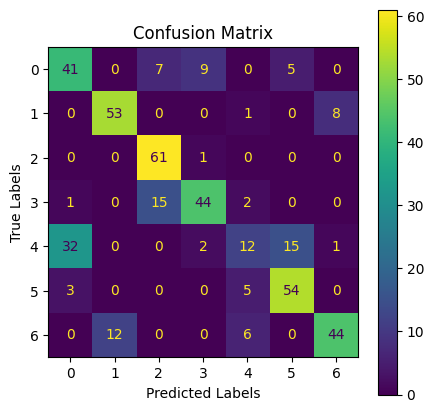


Epoch [4/10] - Loss: 0.6232 - Train Accuracy: 76.93%
Epoch [4/10] - Test Accuracy: 64.06%


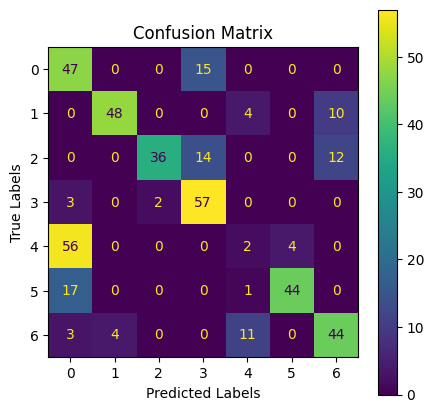


Epoch [5/10] - Loss: 0.5339 - Train Accuracy: 81.13%
Epoch [5/10] - Test Accuracy: 67.51%


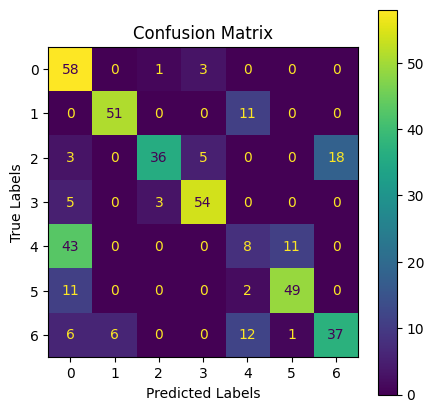


Epoch [6/10] - Loss: 0.4556 - Train Accuracy: 84.67%
Epoch [6/10] - Test Accuracy: 62.90%


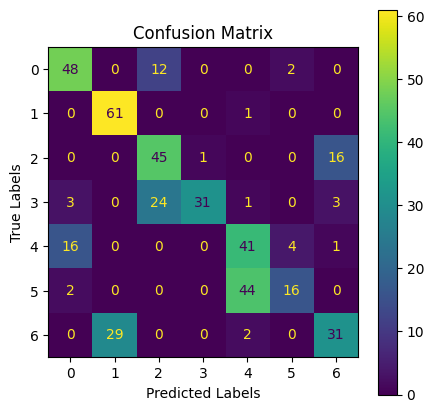


Epoch [7/10] - Loss: 0.2998 - Train Accuracy: 91.48%
Epoch [7/10] - Test Accuracy: 71.43%


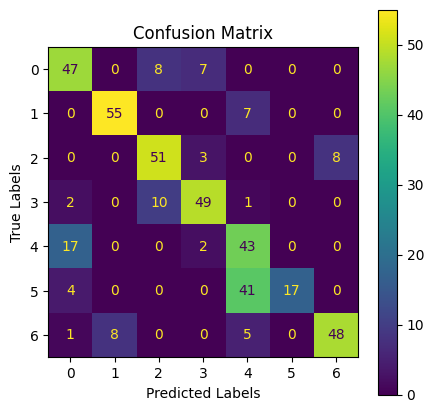


Epoch [8/10] - Loss: 0.2424 - Train Accuracy: 93.97%
Epoch [8/10] - Test Accuracy: 72.12%


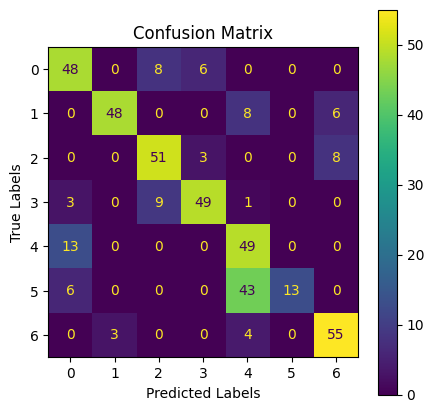


Epoch [9/10] - Loss: 0.2220 - Train Accuracy: 94.04%
Epoch [9/10] - Test Accuracy: 71.66%


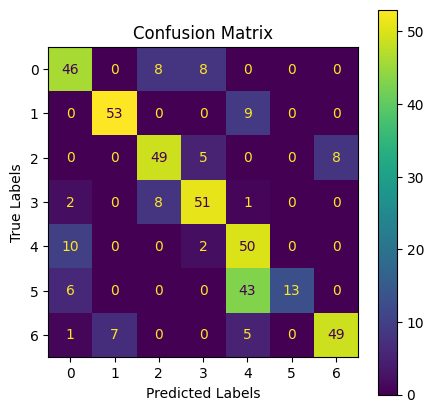


Epoch [10/10] - Loss: 0.2099 - Train Accuracy: 94.76%
Epoch [10/10] - Test Accuracy: 70.51%


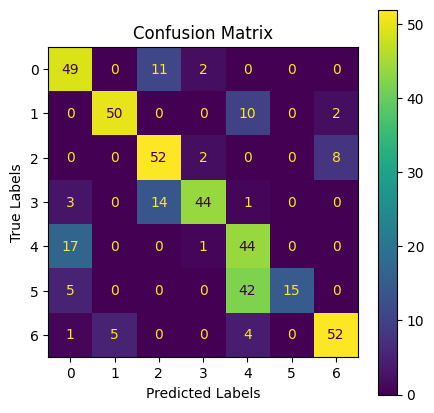

Moving model to QAT!



Epoch [11/10] - Loss: 1.0483 - Train Accuracy: 89.65%
Epoch [11/10] - Test Accuracy: 67.51%


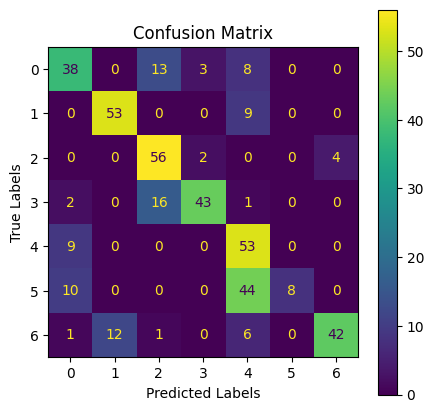


Epoch [12/10] - Loss: 0.4428 - Train Accuracy: 93.25%
Epoch [12/10] - Test Accuracy: 68.43%


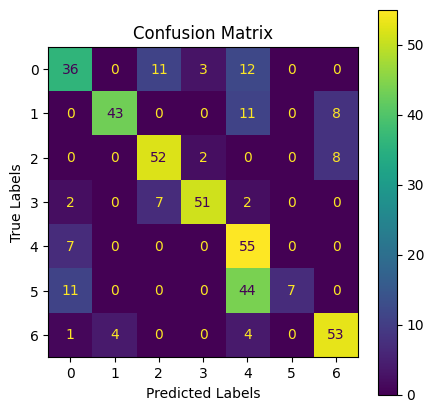


Epoch [13/10] - Loss: 0.3091 - Train Accuracy: 95.41%
Epoch [13/10] - Test Accuracy: 69.35%


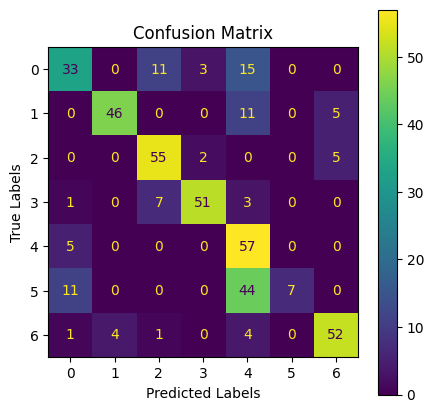


Epoch [14/10] - Loss: 0.2944 - Train Accuracy: 95.48%
Epoch [14/10] - Test Accuracy: 68.89%


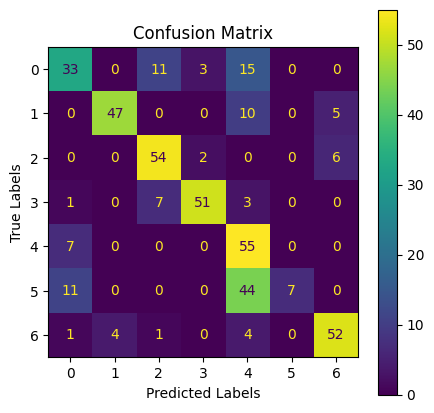


Epoch [15/10] - Loss: 0.2494 - Train Accuracy: 96.00%
Epoch [15/10] - Test Accuracy: 68.43%


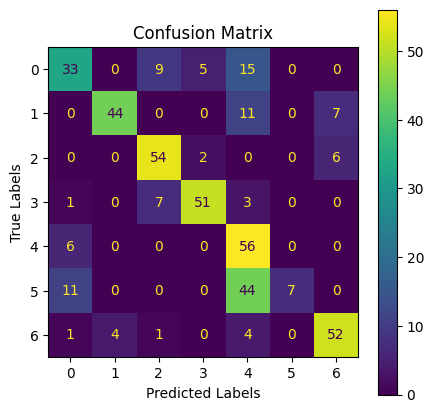


Epoch [16/10] - Loss: 0.2466 - Train Accuracy: 96.20%
Epoch [16/10] - Test Accuracy: 68.43%


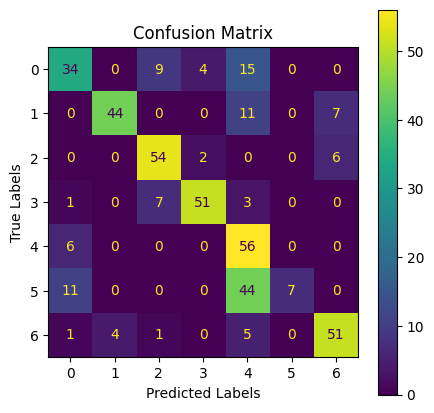


Epoch [17/10] - Loss: 0.2392 - Train Accuracy: 96.26%
Epoch [17/10] - Test Accuracy: 68.20%


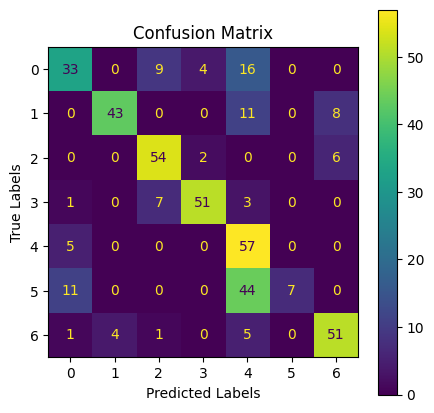


Epoch [18/10] - Loss: 0.2280 - Train Accuracy: 96.13%
Epoch [18/10] - Test Accuracy: 68.20%


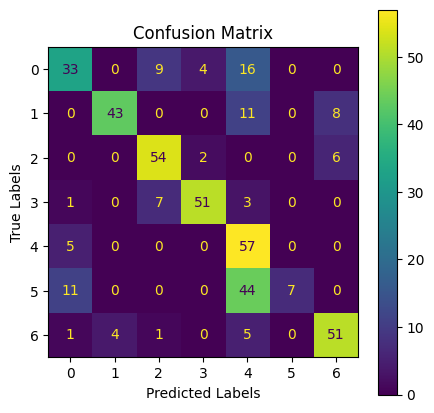


Epoch [19/10] - Loss: 0.2287 - Train Accuracy: 96.07%
Epoch [19/10] - Test Accuracy: 68.43%


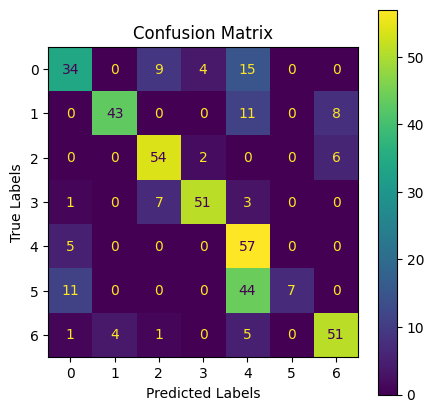


Epoch [20/10] - Loss: 0.2274 - Train Accuracy: 96.40%
Epoch [20/10] - Test Accuracy: 68.20%


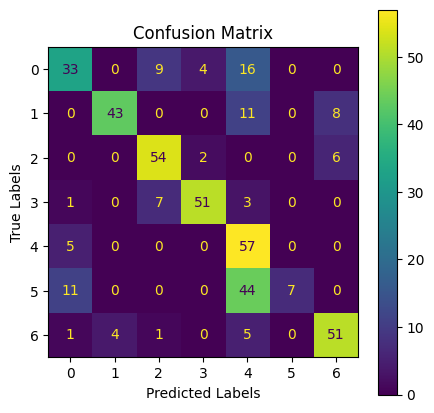

Training finished.


In [12]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []



for epoch in range(num_epochs+num_epochs_qat):
    if epoch == num_epochs:
        print("Moving model to QAT!")
        ai8x.fuse_bn_layers(model)
        ai8x.initiate_qat(model, qat_policy)
        compression_scheduler = distiller.CompressionScheduler(model)
        model.to(device)

    
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for the training loop
    with tqdm(dataset_train, desc=f'Epoch [{epoch + 1}/{num_epochs}]', unit='batch') as tqdm_loader:
        compression_scheduler.on_epoch_begin(epoch, metrics=vloss)
        for train_step, (inputs, labels) in enumerate(tqdm_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()

            compression_scheduler.on_minibatch_begin(epoch, train_step, steps_per_epoch, optimizer)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            compression_scheduler.before_backward_pass(epoch, train_step, steps_per_epoch, loss, optimizer=optimizer, return_loss_components=False)
            loss.backward()
            compression_scheduler.before_parameter_optimization(epoch, train_step, steps_per_epoch, optimizer)
            optimizer.step()
            compression_scheduler.on_minibatch_end(epoch, train_step, steps_per_epoch, optimizer)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update the tqdm progress bar
            tqdm_loader.set_postfix({'Loss': total_loss / (len(tqdm_loader) + 1), 'Accuracy': 100 * correct / total})
        compression_scheduler.on_epoch_end(epoch, optimizer)
    
    # Calculate and print training accuracy and loss for the current epoch
    train_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(dataset_train):.4f} - Train Accuracy: {train_accuracy:.2f}%')
    
    # Evaluation loop (unchanged)
    model.eval()
    correct = 0
    total = 0

    true_labels = []  # Initialize lists to store true labels and predicted labels
    predicted_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataset_val:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true labels and predicted labels to the lists
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    # Calculate and print test accuracy for the current epoch
    test_accuracy = 100 * correct / total
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Accuracy: {test_accuracy:.2f}%')

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Display the confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset_labels)
    fig, ax = plt.subplots(figsize=(5,5))
    display.plot(cmap='viridis', values_format='d', ax=ax)

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    # Speichern der Trainings-Werte
    train_losses.append(total_loss / len(dataset_train))
    train_accuracies.append(train_accuracy)

    # Speichern der Validierungs-Werte
    val_losses.append(test_accuracy)  # Falls du den Verlust brauchst, ergänze ihn
    val_accuracies.append(test_accuracy)
    
    # Adjust learning rate using the scheduler based on test accuracy
    scheduler.step(test_accuracy)

# Training is complete
print('Training finished.')

In [ ]:
import matplotlib.pyplot as plt

# Erstelle zwei Diagramme: eins für den Loss und eins für die Accuracy
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# 📌 Loss-Graph
axs[0].plot(range(len(train_losses)), train_losses, label='Train Loss', color='blue')
axs[0].plot(range(len(val_losses)), val_losses, label='Validation Loss', color='red')
axs[0].set_title('Loss Verlauf über die Epochen')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# 📌 Accuracy-Graph
axs[1].plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy', color='blue')
axs[1].plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy', color='red')
axs[1].set_title('Accuracy Verlauf über die Epochen')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid()

plt.show()


## Evaluation

In [ ]:
model.eval()

correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():  # Kein Gradienten-Tracking nötig
    for inputs, labels in dataset_test:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Speichere Labels für die Konfusionsmatrix
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Berechne die Testgenauigkeit
test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy:.2f}%')

# Erzeuge eine Konfusionsmatrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Konfusionsmatrix visualisieren
display = ConfusionMatrixDisplay(conf_matrix, display_labels=dataset_labels)
fig, ax = plt.subplots(figsize=(5,5))
display.plot(cmap='viridis', values_format='d', ax=ax)

plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Generate sample for the KAT

In [ ]:
x, y = next(iter(dataset_test))
kat_image = (x[0].numpy()*128).astype(np.int64)
kat_image = np.clip(kat_image, -128, 127)

In [ ]:
plt.imshow(kat_image, cmap='viridis', vmin=-128, vmax=127)

In [ ]:
np.save('sample_mnist_40311.npy', kat_image, allow_pickle=False, fix_imports=False)

# Save the model checkpoint (compatible with the synthesizer)

In [ ]:
def save_checkpoint_custom(epoch, arch, model, optimizer=None, scheduler=None, extras=None, name=None, dir='.'):
    """Save a pytorch training checkpoint

    Args:
        epoch: current epoch number
        arch: name of the network architecture/topology
        model: a pytorch model
        optimizer: the optimizer used in the training session
        scheduler: the CompressionScheduler instance used for training, if any
        extras: optional dict with additional user-defined data to be saved in the checkpoint.
            Will be saved under the key 'extras'
        name: the name of the checkpoint file
        dir: directory in which to save the checkpoint
    """
    if not os.path.isdir(dir):
        raise IOError(ENOENT, 'Checkpoint directory does not exist at', os.path.abspath(dir))

    if extras is None:
        extras = {}
    if not isinstance(extras, dict):
        raise TypeError('extras must be either a dict or None')

    filename = 'checkpoint.pth.tar' if name is None else name + '_checkpoint.pth.tar'
    fullpath = os.path.join(dir, filename)
    print("Saving checkpoint to: %s" % fullpath)

    checkpoint = {'epoch': epoch, 'state_dict': model.state_dict(), 'arch': arch}
    with suppress(AttributeError):
        checkpoint['is_parallel'] = model.is_parallel
        checkpoint['dataset'] = model.dataset
        if not arch:
            checkpoint['arch'] = model.arch

    if optimizer is not None:
        checkpoint['optimizer_state_dict'] = optimizer.state_dict()
        checkpoint['optimizer_type'] = type(optimizer)
    if scheduler is not None:
        cstate = scheduler.state_dict()
        # Falls distiller keine Masken angelegt hat (z.B. pruning/sparsity nicht genutzt)
        if 'masks_dict' not in cstate:
            cstate['masks_dict'] = {}
        checkpoint['compression_sched'] = cstate

    if hasattr(model, 'thinning_recipes'):
        checkpoint['thinning_recipes'] = model.thinning_recipes
    if hasattr(model, 'quantizer_metadata'):
        checkpoint['quantizer_metadata'] = model.quantizer_metadata

    checkpoint['extras'] = extras
    torch.save(checkpoint, fullpath)

In [ ]:
save_checkpoint_custom(num_epochs, "1dcnn_final", model, optimizer, scheduler, None, "1dcnn_final_checkpoint", './')

## Berechnung von Zeit und Performance

In [13]:

import time
dummy_input = torch.randn(1, 40, 311).to(device)

model.eval()  # Evaluationsmodus aktivieren
with torch.no_grad():
    # Optional: Warm-Up-Läufe
    for _ in range(100):
        _ = model(dummy_input)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    num_runs = 10000
    start_time = time.time()
    for _ in range(num_runs):
        _ = model(dummy_input)
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_time = time.time()

    total_time = end_time - start_time
    avg_time = total_time / num_runs*1000
    print(f"Durchschnittliche Inferenzzeit mit Dummy Input: {avg_time:.6f} ms")






with torch.no_grad():
    # Warm-Up: ein paar Batches durchlaufen, um Verzögerungen (z. B. CUDA-Initialisierung) zu minimieren
    for i, (inputs, labels) in enumerate(dataset_train):
        inputs = inputs.to(device)
        _ = model(inputs)
        if i >= 5:
            break

    # Synchronisiere alle GPU-Operationen vor dem Start
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    start = time.time()
    for inputs, labels in dataset_train:
        inputs = inputs.to(device)
        _ = model(inputs)
        if torch.cuda.is_available():
            torch.cuda.synchronize()  # Sicherstellen, dass der Batch vollständig abgearbeitet ist
    end = time.time()

    total_time = end - start
    average_time  = total_time/1526*1000 # 1526samples im trainingsdatensatz, *1000 für ms zeit
    print(f"Average Inferenzzeit mit Datensatz verarbeitung: {average_time:.6f} ms")



Durchschnittliche Inferenzzeit mit Dummy Input: 1.923617 ms
Average Inferenzzeit mit Datensatz verarbeitung: 7.675862 ms
